In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import seaborn as sns
pd.options.display.max_columns = None

In [126]:
train = pd.read_csv(r'C:\datasets\Kaggle\Liverpool-ion_swithing\train.csv')
test = pd.read_csv(r'C:\datasets\Kaggle\Liverpool-ion_swithing\test.csv')

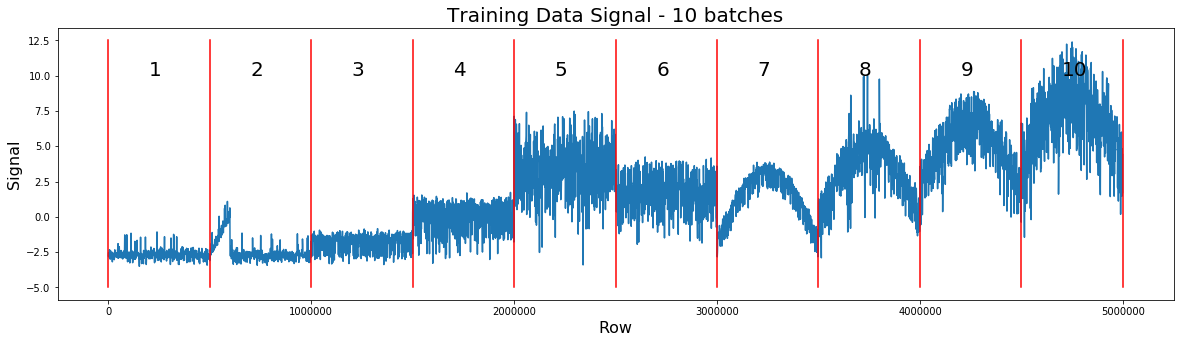

In [127]:
plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train.shape[0],res),train.signal[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)
plt.show()

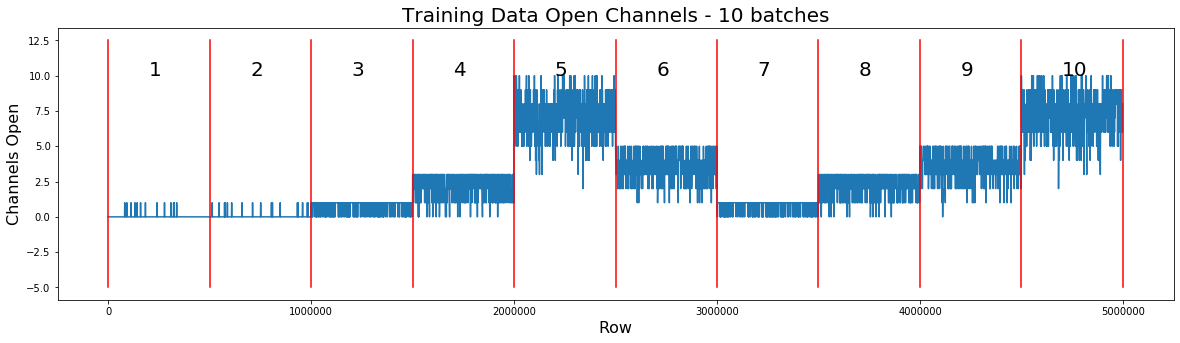

In [128]:
plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train.shape[0],res),train.open_channels[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Channels Open',size=16); 
plt.title('Training Data Open Channels - 10 batches',size=20)
plt.show()

In [130]:
def features(df):
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 25_000
    df['batch_index'] = df.index  - (df.batch * 25_000)
    df['batch_slices'] = df['batch_index']  // 2500
    df['batch_slices2'] = df.apply(lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)
    
    for c in ['batch','batch_slices2']:
        d = {}
        d['mean'+c] = df.groupby([c])['signal'].mean()
        d['median'+c] = df.groupby([c])['signal'].median()
        d['max'+c] = df.groupby([c])['signal'].max()
        d['min'+c] = df.groupby([c])['signal'].min()
        d['std'+c] = df.groupby([c])['signal'].std()
        d['mean_abs_chg'+c] = df.groupby([c])['signal'].apply(lambda x: np.mean(np.abs(np.diff(x))))
        d['abs_max'+c] = df.groupby([c])['signal'].apply(lambda x: np.max(np.abs(x)))
        d['abs_min'+c] = df.groupby([c])['signal'].apply(lambda x: np.min(np.abs(x)))
        d['range'+c] = d['max'+c] - d['min'+c]
        d['maxtomin'+c] = d['max'+c] / d['min'+c]
        d['abs_avg'+c] = (d['abs_min'+c] + d['abs_max'+c]) / 2
        for v in d:
            df[v] = df[c].map(d[v].to_dict())

    
    #add shifts
    df['signal_shift_+1'] = [0,] + list(df['signal'].values[:-1])
    df['signal_shift_-1'] = list(df['signal'].values[1:]) + [0]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_+1'][i] = np.nan
    for i in df[df['batch_index']==49999].index:
        df['signal_shift_-1'][i] = np.nan

    for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]:
        df[c+'_msignal'] = df[c] - df['signal']
        
    return df

In [131]:
train = features(train)
test = features(test)

C:\Users\DruzykRB\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [70]:
from sklearn.model_selection import train_test_split

In [71]:
col = [c for c in train.columns if c not in ['time', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]
#x1, x2, y1, y2 = train_test_split(train[col], train['open_channels'], test_size=0.2, random_state=7)
target = train['open_channels']
train = train[col]

In [76]:
from sklearn.metrics import f1_score

In [77]:
def MacroF1Metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    score = f1_score(labels, preds, average = 'macro')
    return ('MacroF1Metric', score, True)

In [78]:
import lightgbm as lgb
params = {'learning_rate': 0.15} 
model = lgb.train(params, lgb.Dataset(train, target), 100, feval=MacroF1Metric)
preds_lgb = (model.predict(test, num_iteration=model.best_iteration)).astype(np.float16)
#oof_lgb = (model.predict(train, num_iteration=model.best_iteration)).astype(np.float16)
gc.collect()

7827

In [84]:
preds_xgb

array([ 0.0120388 ,  0.01974636,  0.01974636, ..., -0.00041503,
        0.00092995,  0.0009827 ], dtype=float32)

In [80]:
import xgboost as xgb
params = {'colsample_bytree': 0.375,'learning_rate': 0.15, 'objective':'reg:squarederror', 'eval_metric':'rmse'}
train_set = xgb.DMatrix(train, target)
#val_set = xgb.DMatrix(x2, y2)
model = xgb.train(params, train_set, num_boost_round=100, verbose_eval=0)
preds_xgb = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)
#oof_xgb = (model.predict(xgb.DMatrix(train), ntree_limit=model.best_ntree_limit)).astype(np.float16)
#del train_set, val_set; gc.collect()

[00:16:54] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [82]:
from catboost import Pool,CatBoostRegressor
model = CatBoostRegressor(iterations=200, learning_rate=0.15, random_seed = 7, depth=10, eval_metric='RMSE')
train_dataset = Pool(train, target)          
#eval_dataset = Pool(x2,  y2)
model.fit(train_dataset)
preds_cb = (model.predict(test)).astype(np.float16)
#oof_cb = (model.predict(train)).astype(np.float16)
#del train_dataset, eval_dataset, model; gc.collect()

0:	learn: 2.2714743	total: 1.48s	remaining: 4m 54s
1:	learn: 1.9364832	total: 2.82s	remaining: 4m 39s
2:	learn: 1.6524803	total: 4.19s	remaining: 4m 35s
3:	learn: 1.4111346	total: 5.61s	remaining: 4m 35s
4:	learn: 1.2075962	total: 6.98s	remaining: 4m 32s
5:	learn: 1.0348801	total: 8.32s	remaining: 4m 29s
6:	learn: 0.8890424	total: 9.65s	remaining: 4m 26s
7:	learn: 0.7652778	total: 11s	remaining: 4m 23s
8:	learn: 0.6618157	total: 12.3s	remaining: 4m 20s
9:	learn: 0.5750569	total: 13.6s	remaining: 4m 18s
10:	learn: 0.5028985	total: 14.9s	remaining: 4m 16s
11:	learn: 0.4431436	total: 16.3s	remaining: 4m 15s
12:	learn: 0.3937514	total: 17.6s	remaining: 4m 13s
13:	learn: 0.3536790	total: 19s	remaining: 4m 12s
14:	learn: 0.3213442	total: 20.3s	remaining: 4m 10s
15:	learn: 0.2954906	total: 21.7s	remaining: 4m 9s
16:	learn: 0.2748970	total: 23s	remaining: 4m 8s
17:	learn: 0.2589239	total: 24.4s	remaining: 4m 6s
18:	learn: 0.2464649	total: 25.7s	remaining: 4m 5s
19:	learn: 0.2369848	total: 27.1

157:	learn: 0.1858414	total: 3m 30s	remaining: 56.1s
158:	learn: 0.1857890	total: 3m 32s	remaining: 54.7s
159:	learn: 0.1857450	total: 3m 33s	remaining: 53.4s
160:	learn: 0.1857050	total: 3m 34s	remaining: 52.1s
161:	learn: 0.1856673	total: 3m 36s	remaining: 50.7s
162:	learn: 0.1856430	total: 3m 37s	remaining: 49.4s
163:	learn: 0.1856081	total: 3m 38s	remaining: 48s
164:	learn: 0.1855653	total: 3m 40s	remaining: 46.7s
165:	learn: 0.1855277	total: 3m 41s	remaining: 45.4s
166:	learn: 0.1854849	total: 3m 42s	remaining: 44s
167:	learn: 0.1854539	total: 3m 44s	remaining: 42.7s
168:	learn: 0.1854244	total: 3m 45s	remaining: 41.3s
169:	learn: 0.1853953	total: 3m 46s	remaining: 40s
170:	learn: 0.1853374	total: 3m 48s	remaining: 38.7s
171:	learn: 0.1852940	total: 3m 49s	remaining: 37.3s
172:	learn: 0.1852554	total: 3m 50s	remaining: 36s
173:	learn: 0.1852264	total: 3m 52s	remaining: 34.7s
174:	learn: 0.1851790	total: 3m 53s	remaining: 33.3s
175:	learn: 0.1851357	total: 3m 54s	remaining: 32s
176

In [112]:
#final_preds = preds_cb
final_preds = 0.4 * preds_lgb + 0.4 * preds_xgb + 0.2 * preds_cb 
#final_preds = 0.5 * preds_xgb + 0.5 * preds_cb 
#final_oof   = 0.4 * oof_lgb + 0.4 * oof_xgb + 0.2 * oof_cb 

In [ ]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):

    def __init__(self):
        self.coef_ = 0

    def loss(self, coef, X, y):
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
        return -metrics.f1_score(y, X_p, average = 'macro')

    def fit(self, X, y):
        loss_partial = partial(self.loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        return (pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])).astype(np.int8)

    def coefficients(self):
        return self.coef_['x']

In [ ]:
def optimize_predictions(preds, coeffs):
    
    preds[preds <= coeffs[0]] = 0
    preds[np.where(np.logical_and(preds > coeffs[0], preds <= coeffs[1]))] = 1
    preds[np.where(np.logical_and(preds > coeffs[1], preds <= coeffs[2]))] = 2
    preds[np.where(np.logical_and(preds > coeffs[2], preds <= coeffs[3]))] = 3
    preds[np.where(np.logical_and(preds > coeffs[3], preds <= coeffs[4]))] = 4
    preds[np.where(np.logical_and(preds > coeffs[4], preds <= coeffs[5]))] = 5
    preds[np.where(np.logical_and(preds > coeffs[5], preds <= coeffs[6]))] = 6
    preds[np.where(np.logical_and(preds > coeffs[6], preds <= coeffs[7]))] = 7
    preds[np.where(np.logical_and(preds > coeffs[7], preds <= coeffs[8]))] = 8
    preds[np.where(np.logical_and(preds > coeffs[8], preds <= coeffs[9]))] = 9
    preds[preds > coeffs[9]] = 10
    preds = preds.astype(np.int8)
    
    return preds

In [123]:
test['open_channels'] = np.round(np.clip(final_preds, 0, 10)).astype(int)
test[['time','open_channels']].to_csv('C:\datasets\Kaggle\Liverpool-ion_swithing\submission.csv', index=False, float_format='%.4f')

In [115]:
test.open_channels.value_counts()

0     1158368
1      277316
3      135966
2      118301
4       83382
5       59242
7       50469
8       43397
6       42907
9       24244
10       6408
Name: open_channels, dtype: int64